In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit

from stylesheet import *

In [2]:
def load(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

def save(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

In [3]:
# load data
data = load('data_rgb_scaling.pkl')
print(data.keys())

dict_keys(['random states', 'Tensor FRQI, row-by-row', 'Tensor FRQI, hierarchical', 'Tensor FRQI, snake', 'MCRQI, row-by-row', 'MCRQI, hierarchical', 'MCRQI, snake', 'Sum FRQI, row-by-row', 'Sum FRQI, hierarchical', 'Sum FRQI, snake'])


In [4]:
# helper function for plotting error bars as shaded area
def plot_errbar(xdata, ydata, ax, color, marker, ms, ls, fill=True):
    """
    xdata : (len,) ndarray with x values
    ydata : (len, 3) ndarray the last index marks:
                    0 : data that will be plotted as markers
                    1 : data that gives the lower bound of the shaded area
                    2 : data that gives the upper bound of the shaded area
    color : str labeling either a pyplot color or a hex value of a color
    marker : str marker shape
    ms : float marker size
    ls : str line style
    fill : bool wether to plot the shaded area, defaults to True
    """
    if fill:
        ax.fill_between(xdata,
                        *ydata[:,1:].T,
                        alpha=0.2,
                        color=color)
    ax.plot(xdata,
            ydata[:,0],
            marker=marker,
            ms=ms,
            ls=ls,
            linewidth=line_width,
            markeredgecolor="black",
            markeredgewidth=markeredgewidth,
            color=color)

In [5]:
def generate_color_scale(middle_hex: str, total_colors: int = 7) -> list[str]:
    """
    Generate a list of `total_colors` hex codes with `middle_hex` in the exact middle.
    We vary both:
      - Lightness (L in HLS), to get lighter/darker colors
      - Saturation (S in HLS), to avoid overly neon extremes
    """
    import colorsys

    def hex_to_rgb_fraction(hex_color: str):
        """Convert #RRGGBB -> (r, g, b) in [0..1]."""
        hex_color = hex_color.lstrip('#')
        return tuple(int(hex_color[i : i+2], 16) / 255.0 for i in (0, 2, 4))

    # 1) Convert the middle color from hex to HLS
    r, g, b = hex_to_rgb_fraction(middle_hex)
    h, l_mid, s_mid = colorsys.rgb_to_hls(r, g, b)

    # 2) Lightness parameters
    #    Smaller shift => less bright/dark extremes.
    max_shift = 0.2
    l_min = max(l_mid - max_shift, 0.0)
    l_max = min(l_mid + max_shift, 1.0)

    # 3) Saturation parameters
    #    We want to reduce saturation a bit at the extremes to avoid neon look.
    #    The color in the middle keeps its original saturation;
    #    the extremes have ~80% of that saturation (adjust as needed).
    sat_factor_min = 0.80  # e.g., 80% saturation at far ends
    half_side = (total_colors - 1) / 2  # e.g., for 7 colors -> half_side=3

    # 4) We'll space lightness linearly from l_min..l_max.
    #    Then also reduce saturation as we move away from the middle.
    step_size_l = (l_max - l_min) / (total_colors - 1)

    color_list = []
    for i in range(total_colors):
        # Current lightness
        current_l = l_min + i * step_size_l

        # Distance from the middle index in [0..half_side].
        dist = abs(i - half_side)  # e.g., i=0 => dist=3, i=3 => dist=0
        dist_norm = dist / half_side if half_side != 0 else 0  # normalized [0..1]
        
        # Current saturation is linearly scaled from s_mid (at the center) down to s_mid*sat_factor_min (at extremes).
        s_current = s_mid * (1 - dist_norm * (1 - sat_factor_min))

        # Convert HLS -> RGB (floats in [0..1])
        rr, gg, bb = colorsys.hls_to_rgb(h, current_l, s_current)

        # Convert to hex
        color_list.append('#{:02x}{:02x}{:02x}'.format(
            int(rr * 255),
            int(gg * 255),
            int(bb * 255)
        ))

    return color_list

def rgb_to_hex(r, g, b):
    r, g, b = [int(255 * x) for x in (r, g, b)]
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

mid_blue = rgb_to_hex(*color_palette["blue"])
mid_orange = rgb_to_hex(*color_palette["red"])
mid_green = rgb_to_hex(*color_palette["green"])

blues   = generate_color_scale(mid_blue)[::-1]
oranges = generate_color_scale(mid_orange)[::-1]
greens  = generate_color_scale(mid_green)[::-1]

colors = [blues, oranges, greens]


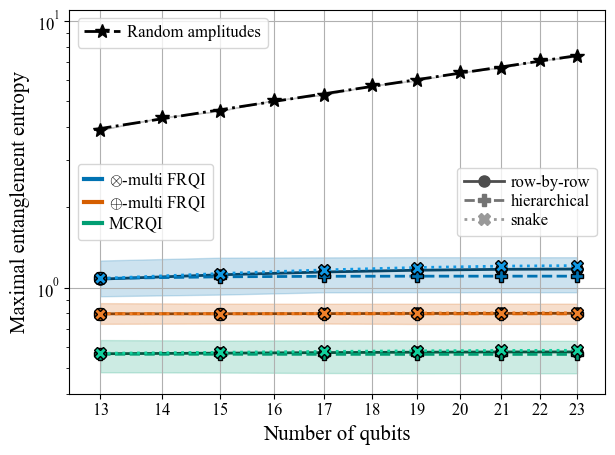

In [7]:
# name of encodings to put into legend
encodings = [r'$\otimes$-multi FRQI', r'$\oplus$-multi FRQI', r'MCRQI']
# name of indexing variants to put into legend
indexings = ['row-by-row', 'hierarchical', 'snake']
markers = ['o-', 'P--', 'X:']

# change figure size
fig, ax = plt.subplots(figsize=(6.4, 4.8))

# plot data for random states
lin = lambda x, a, b: a * x + b
popt, _ = curve_fit(lin, np.arange(13,24), data['random states'][:, 0])
xs = np.linspace(13-0.1, 23+0.1, 101)
ax.plot(xs,
        lin(xs, *popt),
        '-.',
        linewidth=line_width,
        color='k')
plot_errbar(np.arange(13, 24, 1),
            data['random states'],
            ax,
            color='k',
            marker='*',
            ms=marker_size+2,
            ls='')

# plot data for image states
num_qubits = np.arange(13, 23+1, 2)
encoding_keys = ['Tensor FRQI', 'Sum FRQI', 'MCRQI']
indexing_keys = ['row-by-row', 'hierarchical', 'snake']
for i, encoding in enumerate(encodings):
    handles = []
    for j, indexing in enumerate(indexings):
        key = encoding_keys[i] + ', ' + indexing_keys[j]
        plot_errbar(num_qubits,
                    data[key],
                    ax,
                    color=colors[i][-2-2*j],
                    marker=markers[j][0],
                    ms=marker_size,
                    ls=markers[j][1:],
                    fill=(j==1))

ax.set_ylabel('Maximal entanglement entropy')
ax.set_xlabel(r'Number of qubits')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(0.4, 11)
ax.set_xticks(np.arange(13,24),
              [rf'${x:d}$' for x in np.arange(13,24)])

handles = []
for i, encoding in enumerate(encodings):
    handles.append(Line2D([0], [0],
                   lw=3,
                   linewidth=line_width,
                   color=colors[i][3],
                   label=encoding))
l1 = ax.legend(handles=handles,
               loc='center left',
               labelspacing=0.2,
               handlelength=1.075,
               handletextpad=0.4,
               bbox_to_anchor=(0.0,0.4,0.5,0.2))

handles = []
for j, indexing in enumerate(indexings):
    handles.append(Line2D([0], [0],
                          marker=markers[j][:1],
                          ms=marker_size,
                          linewidth=line_width,
                          ls=markers[j][1:],
                          color=str(j*0.15+0.3),
                          label=indexing))
l2 = ax.legend(handles=handles,
               loc='center right',
               labelspacing=0.2,
               handlelength=2.4,
               handletextpad=0.4,
               bbox_to_anchor=(0.5,0.4,0.5,0.2))

handles = [Line2D([0], [0], marker='*', linewidth=line_width, ms=marker_size+2, ls='-.', color='k', label='Random amplitudes')]
l3 = ax.legend(handles=handles,
               loc='upper left',
               labelspacing=0.2,
               handlelength=2.15,
               handletextpad=0.4)

ax.add_artist(l1)
ax.add_artist(l2)
ax.grid(True)

plt.tight_layout()
plt.savefig('rgb_entanglement_scaling.pdf',
            bbox_inches='tight',
            dpi=300)
plt.show()